<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/04_prediction_microcalcificaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import max_norm



# **Descripcion**
---


Existen siete características donde una es la del status relacionada con los microcalcificaciones y no microcalcificaciones. El resto no dispongo información del todo, pero el conjunto es muy usado. Cabe resaltando que esté conjunto de datos es para aprendizaje propio.


# **Objetivo**
---
El objetivo es distinguir entre `microcalcificaciones` y `no microcalcificaciones` usando las características de un objeto segmentado determinado.

- No microcalcificaciones : caso negativo, o clase mayoritaria.
- Microcalcificaciones : caso positivo, o clase minoritaria.

Las `Microcalcificaciones`: Son depósitos diminutos de calcio en el tejido mamario que a menudo se observan en una mamografía.

https://medlineplus.gov/spanish/ency/article/002113.htm



In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/mammography.csv', header=None)
data.head(5)

,0,1,2,3,4,5,6
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11183 entries, 0 to 11182
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       11183 non-null  float64
 1   1       11183 non-null  float64
 2   2       11183 non-null  float64
 3   3       11183 non-null  float64
 4   4       11183 non-null  float64
 5   5       11183 non-null  float64
 6   6       11183 non-null  object 
dtypes: float64(6), object(1)
memory usage: 611.7+ KB


- Las variables de entrenamiento (0:5) son de tipo númerico float
- La variable 6 que representa las microcalcificaciones es de tipo object (categorica)
- Hay 11183 registros y no se aprecia valores faltantes en ninguna columna


In [4]:
data[6].replace({"'-1'":0}, inplace=True)
data[6].replace({"'1'":1}, inplace=True)

In [5]:
data[6].unique()

array([0, 1])

# **Split**
---

In [6]:
data_values = data.values
X = data_values[:, :6]
y = data_values[:, 6]

In [7]:
def plot_bars(data: np.ndarray, title: str= 'feature', x_size:int=6, y_size:int=4, font_size:int=15, x_label:str='churm',y_label:str='count', c_n_churm = '0', c_churm = '1')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax)
  _, data_target = np.unique(data, return_counts=True)
  len_data = data.shape[0]
  pe = '{0:.2f}'.format(data_target[1]/len_data)
  ps = '{0:.2f}'.format(data_target[0]/len_data)
  ax.set_xticklabels([f'{c_n_churm} \n {ps}', f'{c_churm} \n{pe}'])
  ax.set(xlabel=x_label, ylabel=y_label)
  fig.show()

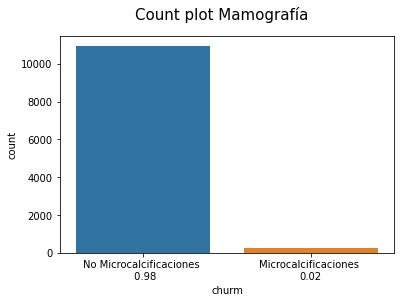

In [8]:
plot_bars(y, title = 'Mamografía', c_churm='Microcalcificaciones', c_n_churm='No Microcalcificaciones')

Hay un serio **desbalance** en el conjunto de datos del 98% No Microcalcificaciones y un 2% Microcalcificaciones, es un desbalance severo.



In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=741, shuffle=True)

In [10]:
estimator = StandardScaler()
X_train_s = estimator.fit_transform(X_train)
X_test_s = estimator.transform(X_test)

# **Model**
---

Se realizarón diversas iteraciones para llegar a la arquitectura propuesta para el presente modelo, cabe resaltar que no se realizo alguna comparativa, puesto que no es el proposito de está actividad.

In [44]:
def model_seleccionado():
  model = Sequential()
  model.add(Dense(15, input_dim = 6, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(5,  activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(2,  activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

In [45]:
model_seleccionado = model_seleccionado()
history = model_seleccionado.fit(X_train_s, y_train, epochs = 300, batch_size = 100, validation_data = (X_test_s, y_test), verbose = 0)

In [46]:
def optimization_learning_curves(history: keras.callbacks.History, metrica, title: str= '', x_size:int=8, y_size:int=4, font_size:int=15, x_label:str='Epoch',y_label:str='Loss')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(title, fontsize = font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(x_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper left', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()

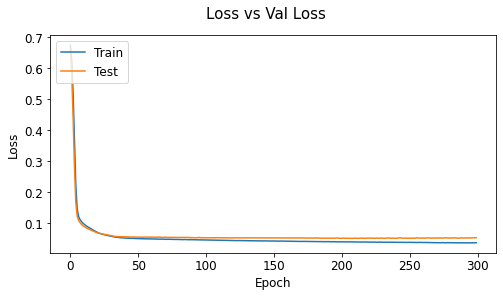

In [47]:
optimization_learning_curves(history, metrica='loss', title='Loss vs Val Loss')

- El modelo tiene una brecha de generalización muy pequeña durante las epocas de entrenameinto

In [48]:
y_pred = (model_seleccionado.predict(X_test_s)>0.5).astype('int32')
y_pred = np.reshape(y_pred, y_pred.shape[0])
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [49]:
def consufion_matrix(validation: np.ndarray, prediction:np.ndarray, churm:str='churm', no_churm:str='no_churm',  title: str= 'Matriz de confusion', x_size:int=6, y_size:int=5)->np.ndarray:
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows= 1, ncols=  1, figsize = (x_size,y_size))
  sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size': 13})
  ax.set_title(title, size = 13)
  ax.xaxis.set_ticklabels([no_churm, churm])
  ax.yaxis.set_ticklabels([no_churm, churm])
  ax.tick_params(labelsize = 13)
  fig.show()
  return matrix

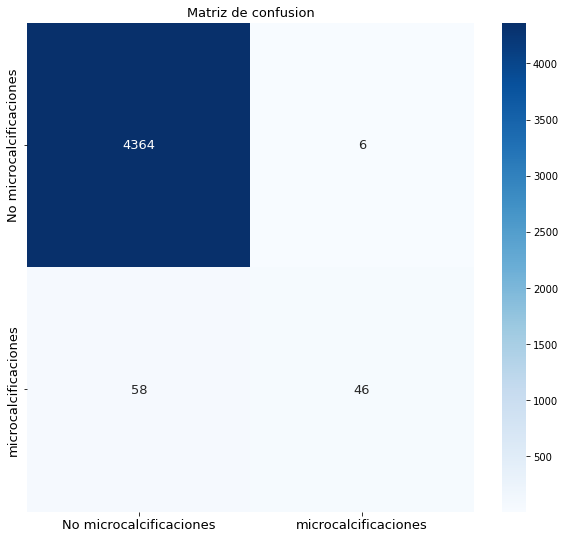

In [50]:
matrix = consufion_matrix(y_test, y_pred,'microcalcificaciones', 'No microcalcificaciones', x_size= 10, y_size = 9)

Para tener pocos registro de microcalcificaciones en coparación con la clase negativa (no microcalcificaciones) el modelo tiene un buen número de vp, por lo tanto puede detecatar de manera correcata la clase de interes, de la misma manera tiene un número alarmante de falso negativos error tipo II. Como el problema es detectar sedimentos para la detección de cancer de maman, el modelo tiene que tener un nivel de predicción mucho mejor.


In [51]:
# Metricas
def metricas(validation: np.ndarray, prediction:np.ndarray, matrix:np.ndarray, label:list=[1])->None:
  print(f'Accuracy  :   {metrics.accuracy_score(validation, prediction)}')
  print(f'Kappa     :   {metrics.cohen_kappa_score(validation, prediction)}')
  print(f'predicción enfermos')
  print(f'Precision:   {metrics.precision_score(validation, prediction, labels=label, average="macro")}')
  print(f'Recall    :   {metrics.recall_score(validation, prediction, labels=label, average="macro")}')

  VN = matrix[0,0]
  FP = matrix[0,1]
  specificity = VN/(VN+FP)

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {metrics.f1_score(validation, prediction, labels=label, average="macro")}' )


In [52]:
metricas(y_test, y_pred, matrix)

Accuracy  :   0.9856951274027715
Kappa     :   0.5832857924578827
predicción enfermos
Precision:   0.8846153846153846
Recall    :   0.4423076923076923
Specificity:   0.9986270022883296
F1-score   :   0.5897435897435898


# **Droput** 
---

Utilizar el modelo seleccionado, aunque está vez aplicare capas con dropout

In [38]:
# Tasa de droput 
# Se impone una restricción en los pesos para cada capa oculta con la norma maxima de los pesos para que no exceda 3, 
# estableciendo el argumento de kernel_constraint en la clase Dense.
# Aumenta la tasa de aprendizaje y el momentum.

def model_dropout():
  model = Sequential()
  model.add(Dropout(0.1, input_dim = 6))
  model.add(Dense(15, activation='relu', kernel_initializer='he_normal', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.1))
  model.add(Dense(5,  activation='relu', kernel_initializer='he_normal', kernel_constraint=max_norm(3)))
  model.add(Dense(2,  activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

In [39]:
model_seleccionado_dropout = model_dropout()
history_dropout = model_seleccionado_dropout.fit(X_train_s, y_train, epochs = 300, batch_size = 100, validation_data = (X_test_s, y_test), verbose = 0)

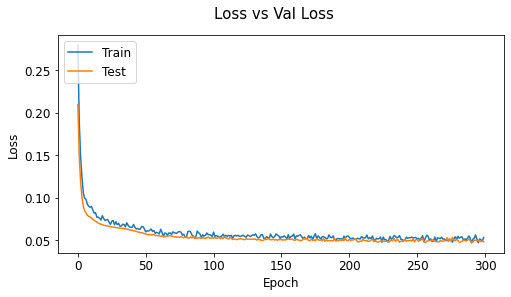

In [40]:
optimization_learning_curves(history_dropout, metrica='loss', title='Loss vs Val Loss')

In [41]:
y_pred_dropout = (model_seleccionado_dropout.predict(X_test_s)>0.5).astype('int32')
y_pred_dropout = np.reshape(y_pred_dropout, y_pred_dropout.shape[0])
y_pred_dropout

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

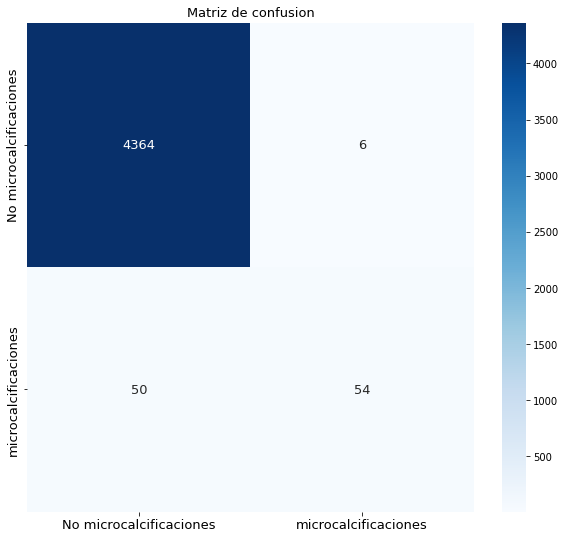

In [42]:
matrix = consufion_matrix(y_test, y_pred_dropout,'microcalcificaciones', 'No microcalcificaciones', x_size= 10, y_size = 9)

In [43]:
metricas(y_test, y_pred_dropout, matrix)

Accuracy  :   0.9874832364774251
Kappa     :   0.6526281930410285
predicción enfermos
Precision:   0.9
Recall    :   0.5192307692307693
Specificity:   0.9986270022883296
F1-score   :   0.6585365853658537


Pese a que se utilizo el dropout en algunas capas del mismo modelo utilizado anteriormente, no se evidencia una mejora sustancial en la predicción de microcalcificaciones. Al ser un problema tán critico no se podria poner en produccón con el rendimiento optenido hasta el momento, pese a que no hallamos medido el rendimiento. 

Se requiere validar otras tecnicas que permitan mejorar el nivel de predicción. Recordenmos que esté es un actividad de `aprendizaje`.